# Backpropagation
Training a neural network to draw a curve.
The curve takes one input variable, the amount travelled along the curve from 0 to 1, and returns 2 outputs, the 2D coordinates of the position of points on the curve.

To help capture the complexity of the curve, we shall use two hidden layers in our network with 6 and 7 neurons respectively.

![Neural network with 2 hidden layers. There is 1 nodes in the zeroth layer, 6 in the first, 7 in the second, and 2 in the third.](images/bigNet.png "The structure of the network we will consider in this assignment.")



## Feed forward

In the following cell, we will define functions to set up our neural network.
Namely an activation function, $\sigma(z)$, it's derivative, $\sigma'(z)$, a function to initialise weights and biases, and a function that calculates each activation of the network using feed-forward.

Recall the feed-forward equations,
$$ \mathbf{a}^{(n)} = \sigma(\mathbf{z}^{(n)}) $$
$$ \mathbf{z}^{(n)} = \mathbf{W}^{(n)}\mathbf{a}^{(n-1)} + \mathbf{b}^{(n)} $$

In this worksheet we will use the *logistic function* as our activation function, rather than the more familiar $\tanh$.
$$ \sigma(\mathbf{z}) = \frac{1}{1 + \exp(-\mathbf{z})} $$



In [1]:
%run "Module/BackpropModule.ipynb"

Populating the interactive namespace from numpy and matplotlib


In [2]:
# PACKAGE
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# PACKAGE
# First load the dependencies.
# Here is the activation function and its derivative.
sigma = lambda z : 1 / (1 + np.exp(-z))
d_sigma = lambda z : np.cosh(z/2)**(-2) / 4

# This function initialises the network with it's structure, it also resets any training already done.
def reset_network (n1 = 6, n2 = 7, random=np.random) :
    global W1, W2, W3, b1, b2, b3
    W1 = random.randn(n1, 1) / 2
    W2 = random.randn(n2, n1) / 2
    W3 = random.randn(2, n2) / 2
    b1 = random.randn(n1, 1) / 2
    b2 = random.randn(n2, 1) / 2
    b3 = random.randn(2, 1) / 2

# This function feeds forward each activation to the next layer. It returns all weighted sums and activations.
def network_function(a0) :
    z1 = W1 @ a0 + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    a2 = sigma(z2)
    z3 = W3 @ a2 + b3
    a3 = sigma(z3)
    return a0, z1, a1, z2, a2, z3, a3

# This is the cost function of a neural network with respect to a training set.
def cost(x, y) :
    return np.linalg.norm(network_function(x)[-1] - y)**2 / x.size

## Backpropagation

We will start with layer 3, which is the easiest, and work backwards through the layers.

We'll define our Jacobians as,
$$ \mathbf{J}_{\mathbf{W}^{(3)}} = \frac{\partial C}{\partial \mathbf{W}^{(3)}} $$
$$ \mathbf{J}_{\mathbf{b}^{(3)}} = \frac{\partial C}{\partial \mathbf{b}^{(3)}} $$
etc., where $C$ is the average cost function over the training set. i.e.,
$$ C = \frac{1}{N}\sum_k C_k $$
The partial derivatives of the cost function are us follows
$$ \frac{\partial C}{\partial \mathbf{W}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}}
   ,$$
for the weight, and similarly for the bias,
$$ \frac{\partial C}{\partial \mathbf{b}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}}
   .$$
With the partial derivatives taking the form,
$$ \frac{\partial C}{\partial \mathbf{a}^{(3)}} = 2(\mathbf{a}^{(3)} - \mathbf{y}) $$
$$ \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}} = \sigma'({z}^{(3)})$$
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}} = \mathbf{a}^{(2)}$$
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}} = 1$$



In [4]:
# Jacobian for the third layer weights.
def J_W3 (x, y) :
    # First get all the activations and weighted sums at each layer of the network.
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    # We'll use the variable J to store parts of our result as we go along, updating it in each line.
    # Firstly, we calculate dC/da3, using the expressions above.
    J = 2 * (a3 - y)
    # Next multiply the result we've calculated by the derivative of sigma, evaluated at z3.
    J = J * d_sigma(z3)
    # Then we take the dot product (along the axis that holds the training examples) with the final partial derivative,
    # i.e. dz3/dW3 = a2
    # and divide by the number of training examples, for the average over all training examples.
    J = J @ a2.T / x.size
    #print(a2.shape)
    # Finally return the result out of the function.
    return J

# As you will see from the partial derivatives, only the last partial derivative is different.
# The first two partial derivatives are the same as previously.
def J_b3 (x, y) :
    # As last time, we'll first set up the activations.
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    # For the final line, we don't need to multiply by dz3/db3, because that is multiplying by 1.
    # We still need to sum over all training examples however.
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

We'll next do the Jacobian for the Layer 2. The partial derivatives for this are,
$$ \frac{\partial C}{\partial \mathbf{W}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \right)
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{W}^{(2)}}
   ,$$
$$ \frac{\partial C}{\partial \mathbf{b}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \right)
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{b}^{(2)}}
   .$$
This is very similar to the previous layer, with two exceptions:
* There is a new partial derivative, in parentheses, $\frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}$
* The terms after the parentheses are now one layer lower.

Recall the new partial derivative takes the following form,
$$ \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}} =
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{a}^{(2)}} =
   \sigma'(\mathbf{z}^{(3)})
   \mathbf{W}^{(3)}
$$

To show how this changes things, we will implement the Jacobian for the weight again and ask you to implement it for the bias.

In [5]:

# Compare this function to J_W3 to see how it changes.
def J_W2 (x, y) :
    #The first two lines are identical to in J_W3.
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)    
    J = 2 * (a3 - y)
    # the next two lines implement da3/da2, first σ' and then W3.
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    # then the final lines are the same as in J_W3 but with the layer number bumped down.
    J = J * d_sigma(z2)
    J = J @ a1.T / x.size
    #print(a1.shape)

    return J

def J_b2 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

Layer 1 is very similar to Layer 2, but with an addition partial derivative term.
$$ \frac{\partial C}{\partial \mathbf{W}^{(1)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{a}^{(1)}}
   \right)
   \frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}
   \frac{\partial \mathbf{z}^{(1)}}{\partial \mathbf{W}^{(1)}}
   ,$$
$$ \frac{\partial C}{\partial \mathbf{b}^{(1)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{a}^{(1)}}
   \right)
   \frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}
   \frac{\partial \mathbf{z}^{(1)}}{\partial \mathbf{b}^{(1)}}
   .$$


In [6]:

def J_W1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    J = J * d_sigma(z1)
    J = J @ a0.T / x.size
    #print(a0.shape)
    return J

def J_b1 (x, y) :
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * d_sigma(z3)
    J = (J.T @ W3).T
    J = J * d_sigma(z2)
    J = (J.T @ W2).T
    J = J * d_sigma(z1)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

## Test 

First, we generate training data, and generate a network with randomly assigned weights and biases.

In [7]:
x, y = training_data()
reset_network()


Next, if you've implemented the assignment correctly, the following code will iterate through a steepest descent algorithm using the Jacobians you have calculated.
The function will plot the training data (in green), and your neural network solutions in pink for each iteration, and orange for the last output.

It takes about 50,000 iterations to train this network.
We can split this up though - **50,000 iterations should take about a minute to run**.
Run the line below as many times as you like.

<IPython.core.display.Javascript object>


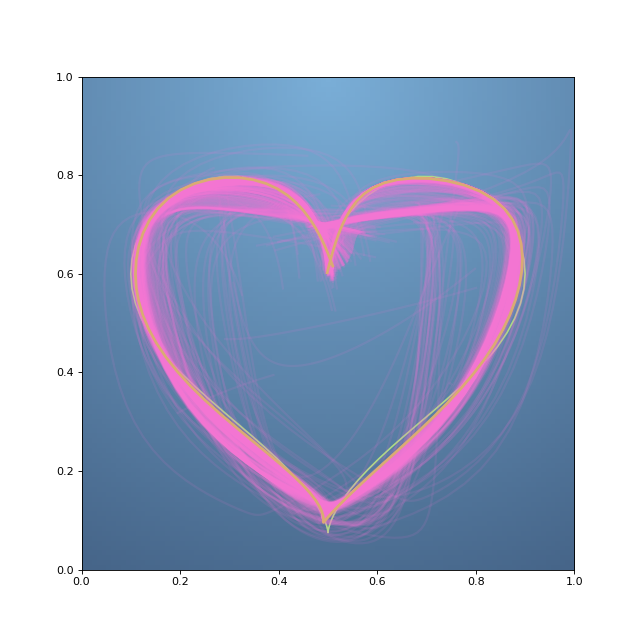

In [8]:
plot_training(x, y, iterations=50000, aggression=7, noise=1)

If you wish, you can change parameters of the steepest descent algorithm, but you can change how many iterations are plotted, how agressive the step down the Jacobian is, and how much noise to add.

You can also edit the parameters of the neural network, i.e. to give it different amounts of neurons in the hidden layers by calling,
```python
reset_network(n1, n2)
```
